In [ ]:
import torch
import numpy as np

# Set data type
DTYPE = torch.float32

# Set constants
pi = torch.tensor(np.pi, dtype=DTYPE)
viscosity = 0.01 / pi

# Define initial condition
def fun_u_0(x):
    return -torch.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return torch.zeros((n, 1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx


In [ ]:
import torch

# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.0
tmax = 1.0
xmin = -1.0
xmax = 1.0

# Lower bounds
lb = torch.tensor([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = torch.tensor([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
torch.manual_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = torch.ones((N_0, 1), dtype=DTYPE) * lb[0]
x_0 = torch.rand((N_0, 1), dtype=DTYPE) * (ub[1] - lb[1]) + lb[1]
X_0 = torch.cat([t_0, x_0], dim=1)

# Evaluate initial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = torch.rand((N_b, 1), dtype=DTYPE) * (ub[0] - lb[0]) + lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * (torch.rand((N_b, 1), dtype=DTYPE) > 0.5).float()
X_b = torch.cat([t_b, x_b], dim=1)

# Evaluate boundary condition at (t_b, x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = torch.rand((N_r, 1), dtype=DTYPE) * (ub[0] - lb[0]) + lb[0]
x_r = torch.rand((N_r, 1), dtype=DTYPE) * (ub[1] - lb[1]) + lb[1]
X_r = torch.cat([t_r, x_r], dim=1)

# Collect boundary and initial data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]


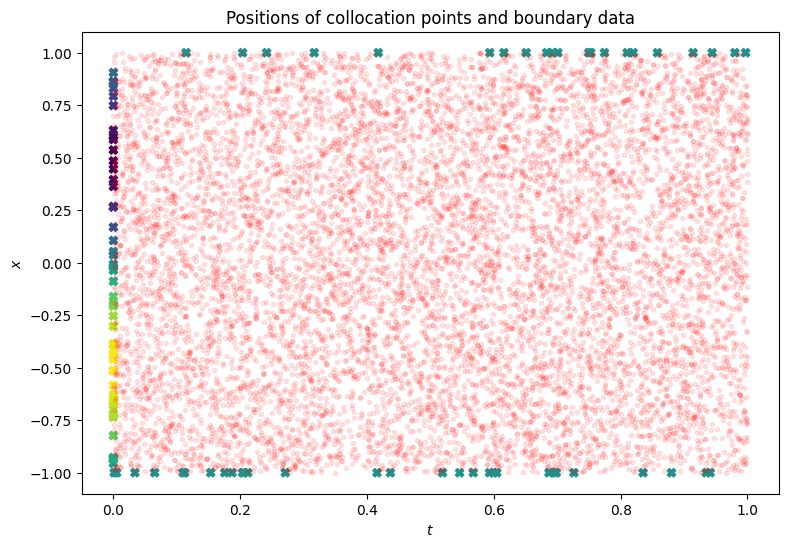

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0.numpy(), x_0.numpy(), c=u_0.numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_b.numpy(), x_b.numpy(), c=u_b.numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_r.numpy(), x_r.numpy(), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Positions of collocation points and boundary data')
# plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the scaling layer
class ScalingLayer(nn.Module):
    def __init__(self, lb, ub):
        super(ScalingLayer, self).__init__()
        self.lb = lb
        self.ub = ub

    def forward(self, x):
        return 2.0 * (x - self.lb) / (self.ub - self.lb) - 1.0

# Define the neural network model
class FeedforwardNN(nn.Module):
    def __init__(self, lb, ub, num_hidden_layers=8, num_neurons_per_layer=20):
        super(FeedforwardNN, self).__init__()
        self.scaling_layer = ScalingLayer(lb, ub)
        self.hidden_layers = nn.ModuleList()

        # Input layer
        self.hidden_layers.append(nn.Linear(2, num_neurons_per_layer))

        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))

        # Output layer
        self.output_layer = nn.Linear(num_neurons_per_layer, 1)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden_layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_normal_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        x = self.scaling_layer(x)
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        x = self.output_layer(x)
        return x

# Example usage
lb = torch.tensor([tmin, xmin], dtype=DTYPE)
ub = torch.tensor([tmax, xmax], dtype=DTYPE)
model = FeedforwardNN(lb, ub, num_hidden_layers=8, num_neurons_per_layer=20)


In [ ]:
model

FeedforwardNN(
  (scaling_layer): ScalingLayer()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-7): 7 x Linear(in_features=20, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [ ]:
def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx)

In [ ]:
def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = torch.mean(r ** 2)

    # Initialize loss
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += torch.mean((u_data[i] - u_pred) ** 2)

    return loss

In [ ]:
def get_grad(model, X_r, X_data, u_data):
    # Set the model to training mode (optional, for layers like dropout/batchnorm)
    model.train()

    # Clear previous gradients
    model.zero_grad()

    # Compute the loss
    loss = compute_loss(model, X_r, X_data, u_data)

    # Compute gradients
    loss.backward()

    # Collect gradients for each parameter
    gradients = [param.grad for param in model.parameters()]

    return loss.item(), gradients

In [ ]:
import torch.optim as optim

# Initialize model
model = FeedforwardNN(lb, ub, num_hidden_layers=8, num_neurons_per_layer=20)

# Define a piecewise decay of the learning rate
def piecewise_learning_rate(step):
    if step < 1000:
        return 1e-2
    elif step < 3000:
        return 1e-3
    else:
        return 5e-4

# Define a custom learning rate scheduler
class CustomLR:
    def __init__(self, optimizer, lr_lambda):
        self.optimizer = optimizer
        self.lr_lambda = lr_lambda
        self.last_epoch = 0

    def step(self):
        self.last_epoch += 1
        lr = self.lr_lambda(self.last_epoch)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-2)  # Initial learning rate, will be updated by scheduler

# Initialize the learning rate scheduler
scheduler = CustomLR(optimizer, piecewise_learning_rate)

# Example usage in training loop
# for epoch in range(num_epochs):
#     ...
#     optimizer.step()
#     scheduler.step()  # Update the learning rate
#     ...


In [ ]:
from time import time

# Define one training step
def train_step(model, optimizer, X_r, X_data, u_data):
    # Compute current loss and gradient w.r.t. parameters
    loss, gradients = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optimizer.step()

    # Clear the gradients after updating
    optimizer.zero_grad()

    return loss

# Number of training epochs
N = 5000
hist = []

# Initialize model and optimizer
model = FeedforwardNN(lb, ub, num_hidden_layers=8, num_neurons_per_layer=20)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = CustomLR(optimizer, piecewise_learning_rate)

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step(model, optimizer, X_r, X_data, u_data)

    # Append current loss to hist
    hist.append(loss)

    # Output current loss after 50 iterates
    if i % 50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i, loss))

    # Update the learning rate
    scheduler.step()

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

NameError: name 'tf' is not defined

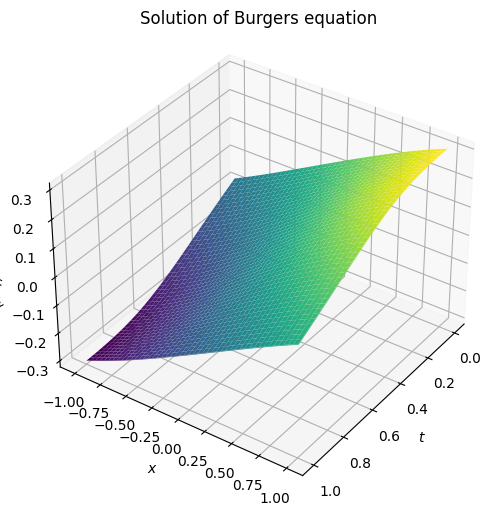

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming lb and ub are tensors with the lower and upper bounds
lb = torch.tensor([tmin, xmin], dtype=DTYPE)
ub = torch.tensor([tmax, xmax], dtype=DTYPE)

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0].item(), ub[0].item(), N + 1)
xspace = np.linspace(lb[1].item(), ub[1].item(), N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(), X.flatten()]).T

# Determine predictions of u(t, x)
Xgrid_tensor = torch.tensor(Xgrid, dtype=DTYPE)
with torch.no_grad():
    upred = model(Xgrid_tensor)

# Reshape upred
U = upred.numpy().reshape(N+1, N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(35, 35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation')
# plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300)
plt.show()


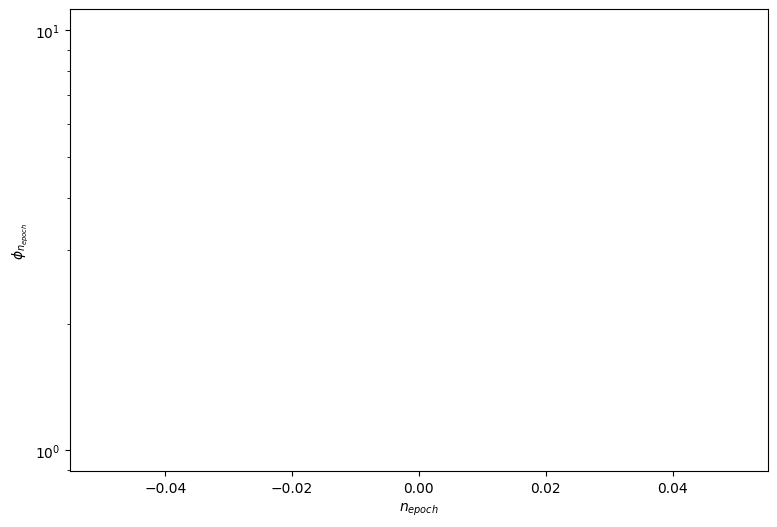

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class PINN_NeuralNet(nn.Module):
    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal'):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        self.scale = ScalingLayer(lb, ub)
        self.hidden = nn.ModuleList([nn.Linear(num_neurons_per_layer, num_neurons_per_layer)
                                     for _ in range(self.num_hidden_layers)])
        self.out = nn.Linear(num_neurons_per_layer, output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.hidden:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_normal_(self.out.weight)
        nn.init.zeros_(self.out.bias)

    def forward(self, X):
        Z = self.scale(X)
        for layer in self.hidden:
            Z = torch.tanh(layer(Z))
        return self.out(Z)



In [ ]:
import torch
import torch.optim as optim
import numpy as np
import scipy.optimize

class PINNSolver():
    def __init__(self, model, X_r):
        self.model = model

        # Store collocation points
        self.t = torch.tensor(X_r[:, 0:1], dtype=DTYPE, requires_grad=True)
        self.x = torch.tensor(X_r[:, 1:2], dtype=DTYPE, requires_grad=True)

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0

    def get_r(self):
        u = self.model(torch.cat([self.t, self.x], dim=1))
        u_x = torch.autograd.grad(u, self.x, torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, self.t, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, self.x, torch.ones_like(u_x), create_graph=True)[0]

        return self.fun_r(self.t, self.x, u, u_t, u_x, u_xx)

    def loss_fn(self, X, u):
        r = self.get_r()
        phi_r = torch.mean(r ** 2)
        loss = phi_r

        for i in range(len(X)):
            u_pred = self.model(X[i])
            loss += torch.mean((u[i] - u_pred) ** 2)

        return loss

    def get_grad(self, X, u):
        loss = self.loss_fn(X, u)
        grad_theta = torch.autograd.grad(loss, self.model.parameters(), create_graph=True)

        return loss, grad_theta

    def fun_r(self, t, x, u, u_t, u_x, u_xx):
        """Residual of the PDE"""
        return u_t + u * u_x - viscosity * u_xx

    def solve_with_TFoptimizer(self, optimizer, X, u, N=1001):
        """This method performs a gradient descent type optimization."""

        for i in range(N):
            loss, _ = self.get_grad(X, u)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            self.current_loss = loss.item()
            self.callback()

    def solve_with_ScipyOptimizer(self, X, u, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize."""

        def get_weight_tensor():
            return torch.cat([v.flatten() for v in self.model.parameters()])

        x0 = get_weight_tensor().detach().cpu().numpy()

        def set_weight_tensor(weight_list):
            idx = 0
            for v in self.model.parameters():
                numel = v.numel()
                v.data.copy_(torch.tensor(weight_list[idx:idx+numel], dtype=DTYPE).view(v.shape))
                idx += numel

        def get_loss_and_grad(w):
            set_weight_tensor(w)
            loss, grad = self.get_grad(X, u)
            loss = loss.item()
            self.current_loss = loss
            grad_flat = torch.cat([g.flatten() for g in grad]).detach().cpu().numpy()
            return loss, grad_flat

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)

    def callback(self, xr=None):
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss))
        self.hist.append(self.current_loss)
        self.iter+=1


    def plot_solution(self, **kwargs):
        N = 600
        tspace = np.linspace(self.model.lb[0], self.model.ub[0], N+1)
        xspace = np.linspace(self.model.lb[1], self.model.ub[1], N+1)
        T, X = np.meshgrid(tspace, xspace)
        Xgrid = np.vstack([T.flatten(),X.flatten()]).T
        upred = self.model(torch.tensor(Xgrid, dtype=DTYPE))
        U = upred.detach().cpu().numpy().reshape(N+1,N+1)
        fig = plt.figure(figsize=(9,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_zlabel('$u_\\theta(t,x)$')
        ax.view_init(35,35)
        return ax

    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7,5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist,'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax


In [ ]:
# Initialize model
model = PINN_NeuralNet(lb, ub)

# Initialize PINN solver
solver = PINNSolver(model, X_r)

# Decide which optimizer should be used
mode = 'ScipyOptimizer'  # You can change to 'TFoptimizer' if needed

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    solver.solve_with_TFoptimizer(optimizer, X_data, u_data, N=4001)

elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_data, u_data,
                                      method='L-BFGS-B',
                                      options={'maxiter': 50000,
                                               'maxfun': 50000,
                                               'maxcor': 50,
                                               'maxls': 50,
                                               'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


<ipython-input-20-eec25c1575a1>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t = torch.tensor(X_r[:, 0:1], dtype=DTYPE, requires_grad=True)
<ipython-input-20-eec25c1575a1>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(X_r[:, 1:2], dtype=DTYPE, requires_grad=True)


It 00000: loss = 5.82623243e-01
It 00050: loss = 1.46406710e-01
It 00100: loss = 1.25308767e-01
It 00150: loss = 1.05850287e-01
It 00200: loss = 8.29941779e-02
It 00250: loss = 5.65043800e-02
It 00300: loss = 3.21479291e-02
It 00350: loss = 1.81719884e-02
It 00400: loss = 1.12916287e-02
It 00450: loss = 7.41468510e-03
It 00500: loss = 5.60906576e-03
It 00550: loss = 3.74443270e-03
It 00600: loss = 2.50333385e-03
It 00650: loss = 1.80332444e-03
It 00700: loss = 1.31732435e-03
It 00750: loss = 8.96714104e-04
It 00800: loss = 7.01839686e-04
It 00850: loss = 5.80521009e-04
It 00900: loss = 4.62236785e-04
It 00950: loss = 3.87180888e-04
It 01000: loss = 3.26146226e-04
It 01050: loss = 2.76710431e-04
It 01100: loss = 2.40941576e-04
It 01150: loss = 2.02390947e-04
It 01200: loss = 1.80320116e-04
It 01250: loss = 1.60475436e-04
It 01300: loss = 1.43227269e-04
It 01350: loss = 1.26798419e-04
It 01400: loss = 1.19150114e-04
It 01450: loss = 1.08479086e-04
It 01500: loss = 9.78956959e-05
It 01550

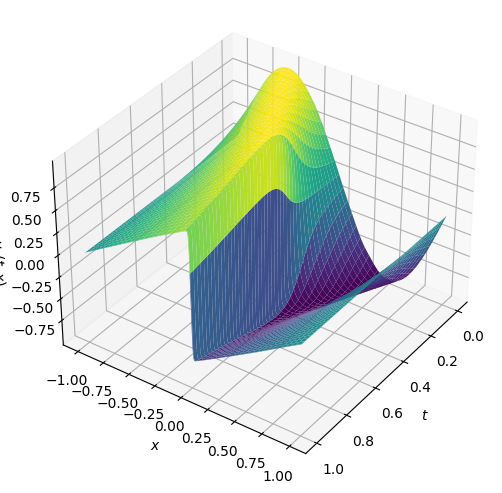

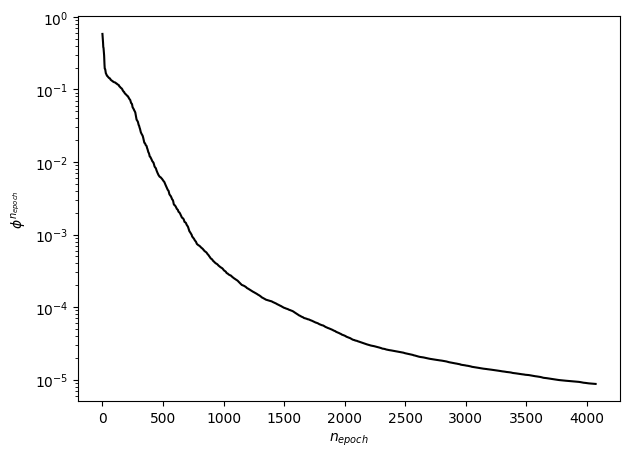

In [ ]:
solver.plot_solution();
solver.plot_loss_history();